To run everything, download the dataset from https://www.kaggle.com/mrmorj/hate-speech-and-offensive-language-dataset and http://nlp.stanford.edu/data/glove.6B.zip

#Old Stuff with Twitter API, ignore

In [ ]:
!pip install python-twitter

In [ ]:
import sys
import operator
import requests
import json
import twitter

twitter_consumer_key = 'XenF9IuouS2zFVXOrTiJvsGWY'
twitter_consumer_secret = 'Ays1kvKDEEfKWa9bhpChl9W331hIREXzbrgLNaV8jf0tGtkuyN'
twitter_access_token = '806930226122919936-tPQGhXJub1xa5wxoSJTG7pS36HRMFfT'
twitter_access_secret = 'HYdvQs2JWPoB5rVfyfBxbmakkCbWFk9mrA07fRrWmTAXm'
twitter_api = twitter.Api(consumer_key=twitter_consumer_key, consumer_secret=twitter_consumer_secret, access_token_key=twitter_access_token, access_token_secret=twitter_access_secret)

#Getting the Data

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import re,string
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

tweets = pd.read_csv('/content/labeled_data.csv',header=None)
columns = tweets.iloc[0]
tweets = tweets[1:]
tweets.columns =columns

In [ ]:
tweets.head(15)

,NaN,count,hate_speech,offensive_language,neither,class,tweet
1,0.0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
2,1.0,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
3,2.0,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
4,3.0,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
5,4.0,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
6,5.0,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
7,6.0,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
8,7.0,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
9,8.0,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
10,9.0,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [ ]:
for x in tweets["tweet"][10:25]:
  print(x)

" Keeks is a bitch she curves everyone " lol I walked into a conversation like this. Smh
" Murda Gang bitch its Gang Land "
" So hoes that smoke are losers ? " yea ... go on IG
" bad bitches is the only thing that i like "
" bitch get up off me "
" bitch nigga miss me with it "
" bitch plz whatever "
" bitch who do you love "
" bitches get cut off everyday B "
" black bottle &amp; a bad bitch "
" broke bitch cant tell me nothing "
" cancel that bitch like Nino "
" cant you see these hoes wont change "
" fuck no that bitch dont even suck dick " &#128514;&#128514;&#128514; the Kermit videos bout to fuck IG up
" got ya bitch tip toeing on my hardwood floors " &#128514; http://t.co/cOU2WQ5L4q


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 1 to 24783
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nan                 24783 non-null  float64
 1   count               24783 non-null  object 
 2   hate_speech         24783 non-null  object 
 3   offensive_language  24783 non-null  object 
 4   neither             24783 non-null  object 
 5   class               24783 non-null  object 
 6   tweet               24783 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.3+ MB


In [ ]:
tweets = tweets[["class", "tweet"]]
tweets['class'] = tweets['class'].map({'0': 1, '1': 0,'2':0})
#0 represents hate speech
#1 represents offensive speech or neither of the two
tweets.head()

,class,tweet
1,0,!!! RT @mayasolovely: As a woman you shouldn't...
2,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
4,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
5,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(punctuation)
stop.update(punctuation)
def clean_text(text):
    #text = re.sub('\[[^]]*\]', '', text)
    text= re.sub('!','', text)
    text = re.sub('RT', ' ', text) #retweet symbol
    text = re.sub(r'&#([0-9_]+)','', text)
    text = re.sub(r'@[^\s]+','', text) #twitter handles
    text = re.sub(r'http\S+', '', text) #hyperlinks
    text = " ".join([x for x in text.split() if x.strip().lower() not in stop])
    return text
tweets['tweet']=tweets['tweet'].apply(clean_text)

In [ ]:
#Cleaned
tweets.head()

,class,tweet
1,0,woman complain cleaning house. &amp; man alway...
2,0,boy dats cold...tyga dwn bad cuffin dat hoe 1s...
3,0,Dawg ever fuck bitch start cry? confused shit
4,0,look like tranny
5,0,shit hear might true might faker bitch told ya


In [ ]:
tweets.loc[tweets['class'] == 0].shape


(23353, 2)

In [ ]:
tweets.loc[tweets['class'] == 1].shape


(1430, 2)

We can see a huge disparity between the two class sizes and will need to account for such with class weighting.

In [ ]:
#Formula for class weighting
#wj=n_samples / (n_classes * n_samplesj)
print(24783/(1430*2))
print(24783/(23353*2))

8.665384615384616
0.53061705134244


In [ ]:
weighting = {0:8.665384615384616,1:0.53061705134244}

**Hate Tweets**

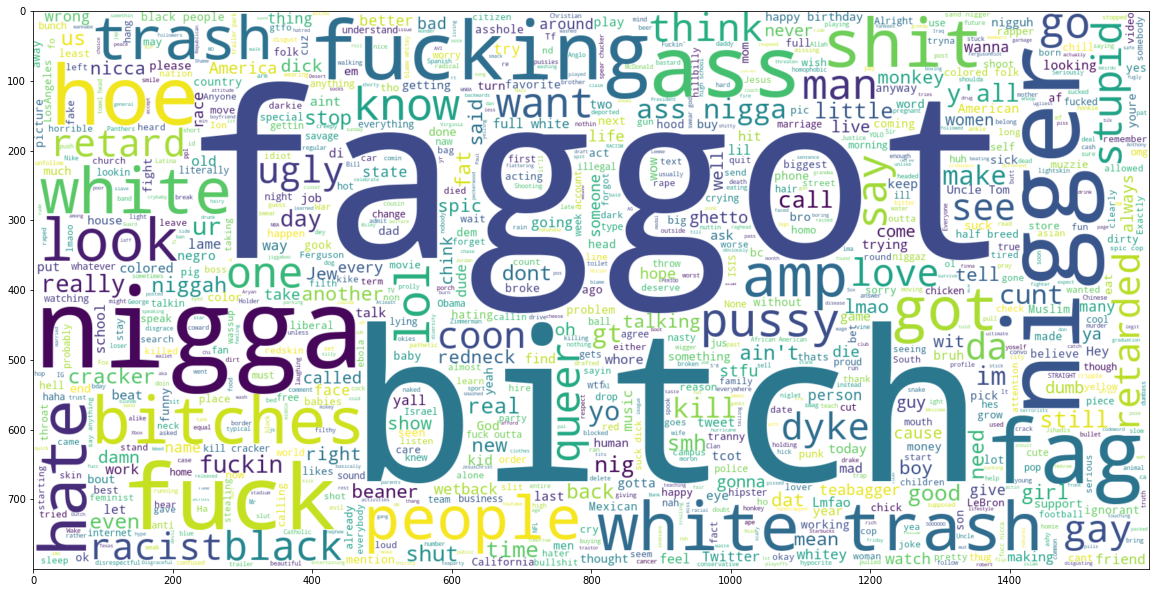

In [ ]:
from wordcloud import WordCloud, STOPWORDS
hate_tweets = tweets[tweets["class"]==1]
other_tweets = tweets[tweets["class"]==0]
plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color ='white', max_words = 1000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(hate_tweets.tweet))
plt.imshow(wc , interpolation = 'bilinear')

**Offensive Tweets**

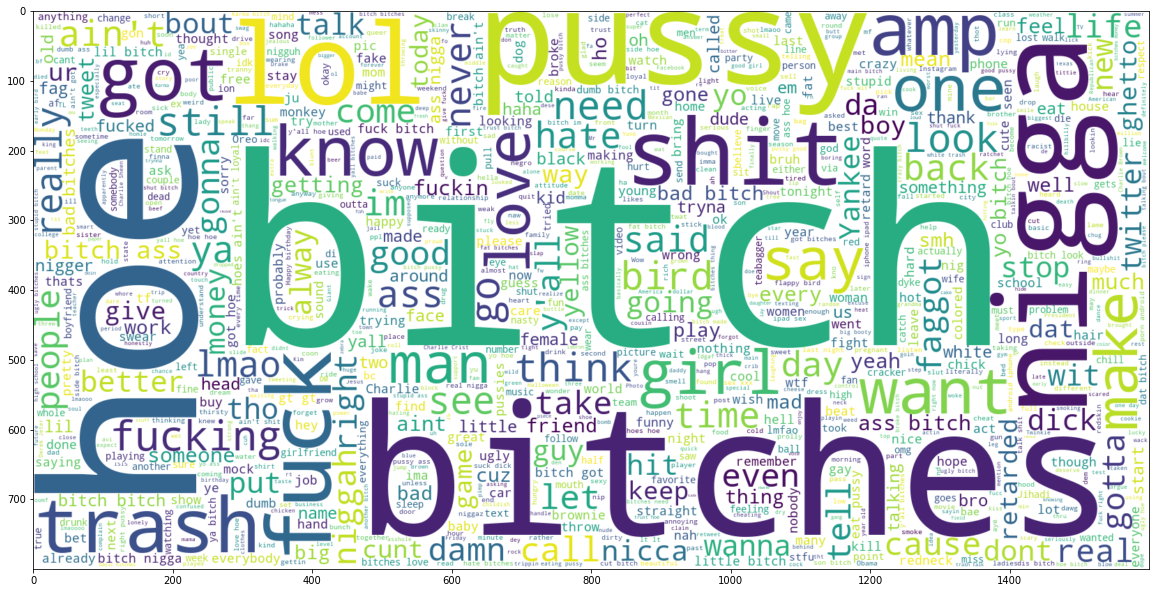

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color ='white', max_words = 1000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(other_tweets.tweet))
plt.imshow(wc , interpolation = 'bilinear')

Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets["tweet"],tweets["class"], test_size=0.20, random_state=42)

# Term frequency-inverse document frequency



# Unigrams

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(stop_words='english', max_df=0.7)
x_vector_train=vectorizer.fit_transform(X_train)
x_vector_test = vectorizer.transform(X_test)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight=weighting)
logreg.fit(x_vector_train,y_train)
log_pred= logreg.predict(x_vector_test)
logreg.score(x_vector_test, y_test)*100

94.1496873108735

Passive Agressive Classifier

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
pac=PassiveAggressiveClassifier(max_iter=250, class_weight=weighting)
pac.fit(x_vector_train,y_train)
pac_pred=pac.predict(x_vector_test)
score=accuracy_score(y_test,pac_pred)
print(score*100)

93.22170667742586


Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 15, class_weight=weighting)
rfc.fit(x_vector_train, y_train)
rfc_pred= rfc.predict(x_vector_test)
rfc.score(x_vector_test,y_test)*100

93.86725842243293

Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, class_weight = weighting)
dtc.fit(x_vector_train,y_train)
dtc_pred = dtc.predict(x_vector_test)
dtc.score(x_vector_test,y_test)*100

92.87875731289085

SVM

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', class_weight = weighting)
svclassifier.fit(x_vector_train, y_train)
y_pred = svclassifier.predict(x_vector_test)
svclassifier.score(x_vector_test,y_test)*100

94.1496873108735

Gaussian Naive Bayes

In [ ]:
#Crashes, uses all available RAM for some reason
'''from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_vector_train.todense(),y_train)
gnb_pred = gnb.predict(x_vector_test)
gnb.score(x_vector_test,y_test)'''

'from sklearn.naive_bayes import GaussianNB\ngnb = GaussianNB()\ngnb.fit(x_vector_train.todense(),y_train)\ngnb_pred = gnb.predict(x_vector_test)\ngnb.score(x_vector_test,y_test)'

Confusion Matrix for Logistic Regression

Text(23.999999999999996, 0.5, 'Actual')

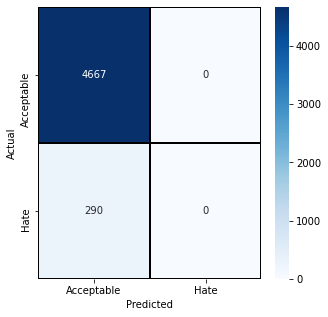

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test,log_pred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Acceptable','Hate'] , yticklabels = ['Acceptable','Hate'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Bigrams

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(stop_words='english',ngram_range = (2, 2), max_df=0.7)
x_vector_train=vectorizer.fit_transform(X_train)
x_vector_test = vectorizer.transform(X_test)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight=weighting)
logreg.fit(x_vector_train,y_train)
log_pred= logreg.predict(x_vector_test)
logreg.score(x_vector_test, y_test)*100

94.1496873108735

Passive Agressive Classifier

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
pac=PassiveAggressiveClassifier(max_iter=250, class_weight=weighting)
pac.fit(x_vector_train,y_train)
pac_pred=pac.predict(x_vector_test)
score=accuracy_score(y_test,pac_pred)
print(score*100)

94.0891668347791


Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 0, class_weight=weighting)
rfc.fit(x_vector_train, y_train)
rfc_pred= rfc.predict(x_vector_test)
rfc.score(x_vector_test,y_test)*100

94.21020778696793

Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, class_weight = weighting)
dtc.fit(x_vector_train,y_train)
dtc_pred = dtc.predict(x_vector_test)
dtc.score(x_vector_test,y_test)*100

93.18135969336292

SVM

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', class_weight = weighting)
svclassifier.fit(x_vector_train, y_train)
svm_pred = svclassifier.predict(x_vector_test)
svclassifier.score(x_vector_test,y_test)*100

94.27072826306232

Gaussian Naive Bayes

In [ ]:
#Crashes, uses all available RAM for some reason
'''from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_vector_train.todense(),y_train)
gnb_pred = gnb.predict(x_vector_test)
gnb.score(x_vector_test,y_test)'''

'from sklearn.naive_bayes import GaussianNB\ngnb = GaussianNB()\ngnb.fit(x_vector_train.todense(),y_train)\ngnb_pred = gnb.predict(x_vector_test)\ngnb.score(x_vector_test,y_test)'

Confusion Matrix for SVM


Text(23.999999999999996, 0.5, 'Actual')

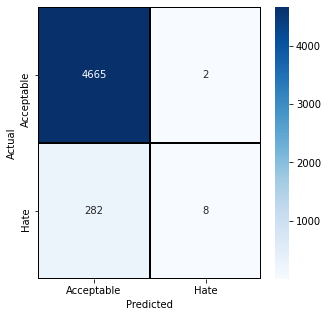

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test,svm_pred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Acceptable','Hate'] , yticklabels = ['Acceptable','Hate'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Trigrams

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(stop_words='english',ngram_range = (3, 3), max_df=0.7)
x_vector_train=vectorizer.fit_transform(X_train)
x_vector_test = vectorizer.transform(X_test)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight=weighting)
logreg.fit(x_vector_train,y_train)
log_pred= logreg.predict(x_vector_test)
logreg.score(x_vector_test, y_test)*100

94.1496873108735

Passive Agressive Classifier

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
pac=PassiveAggressiveClassifier(max_iter=250, class_weight=weighting)
pac.fit(x_vector_train,y_train)
pac_pred=pac.predict(x_vector_test)
score=accuracy_score(y_test,pac_pred)
print(score*100)

93.90760540649586


Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 0, class_weight=weighting)
rfc.fit(x_vector_train, y_train)
rfc_pred= rfc.predict(x_vector_test)
rfc.score(x_vector_test,y_test)*100

94.00847286665322

Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, class_weight = weighting)
dtc.fit(x_vector_train,y_train)
dtc_pred = dtc.predict(x_vector_test)
dtc.score(x_vector_test,y_test)*100

93.90760540649586

Gaussian Naive Bayes

In [ ]:
#Crashes, uses all available RAM for some reason
'''from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_vector_train.todense(),y_train)
gnb_pred = gnb.predict(x_vector_test)
gnb.score(x_vector_test,y_test)'''

'from sklearn.naive_bayes import GaussianNB\ngnb = GaussianNB()\ngnb.fit(x_vector_train.todense(),y_train)\ngnb_pred = gnb.predict(x_vector_test)\ngnb.score(x_vector_test,y_test)'

SVM

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', class_weight = weighting)
svclassifier.fit(x_vector_train, y_train)
svm_pred = svclassifier.predict(x_vector_test)
svclassifier.score(x_vector_test,y_test)*100

94.1496873108735

Confusion Matrix for SVM

Text(23.999999999999996, 0.5, 'Actual')

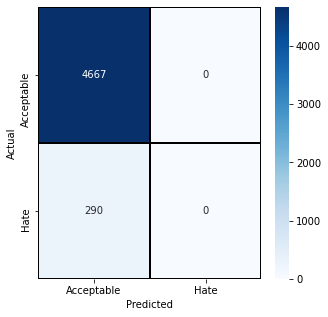

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test,svm_pred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Acceptable','Hate'] , yticklabels = ['Acceptable','Hate'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# GloVe Embeddings

We need to assign varying weights because uneven data set. 

In [ ]:
embeddings_dict = {}
with open("/content/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
#Transform 
#Modeled after tutorial in https://learn.co/lessons/dsc-classification-with-word-embeddings-codealong
class GloveVectorizer(object):
    def __init__(self, w2v):
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(embeddings_dict))])
    def transform(self, X):
        return np.array([np.mean([self.w2v[w] for w in words if w in self.w2v] or [np.zeros(self.dimensions)], axis=0) for words in X])



Display TSNE for Tweets

In [ ]:
words=set()
for x in X_test:
  for y in x.split():
    if y not in words:
      words.add(y)


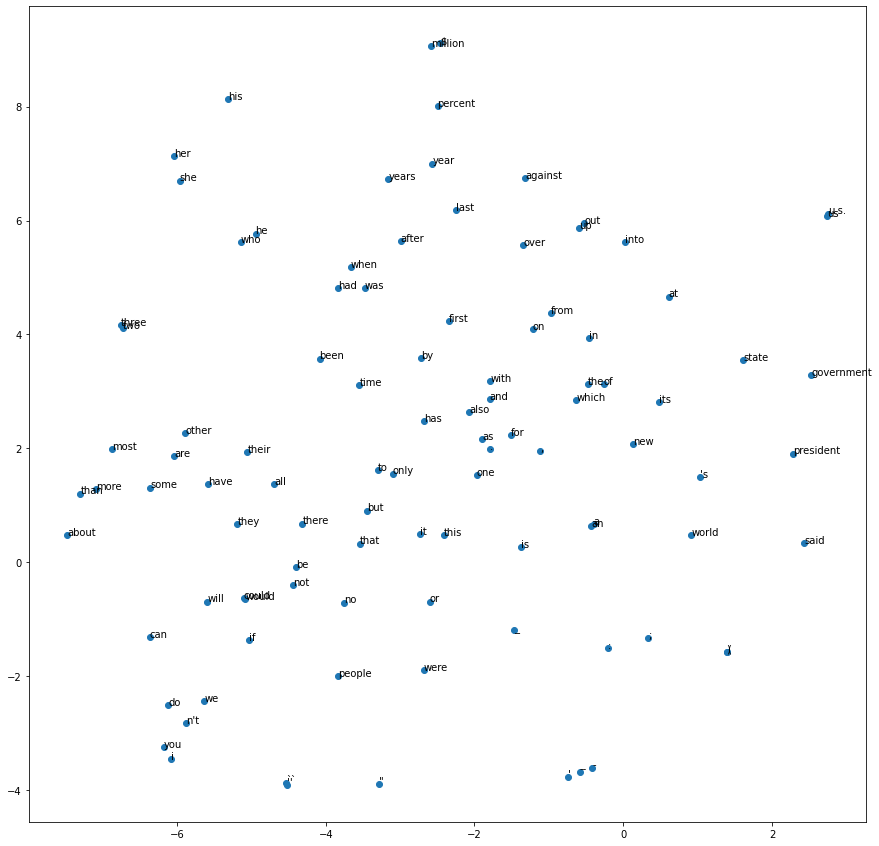

In [ ]:
#100 Words
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words= [word for word in list(words) if word in embeddings_dict.keys()][:100]
vectors = [embeddings_dict[word] for word in words ]
Y = tsne.fit_transform(vectors[:100])
plt.figure(figsize=(15,15))
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

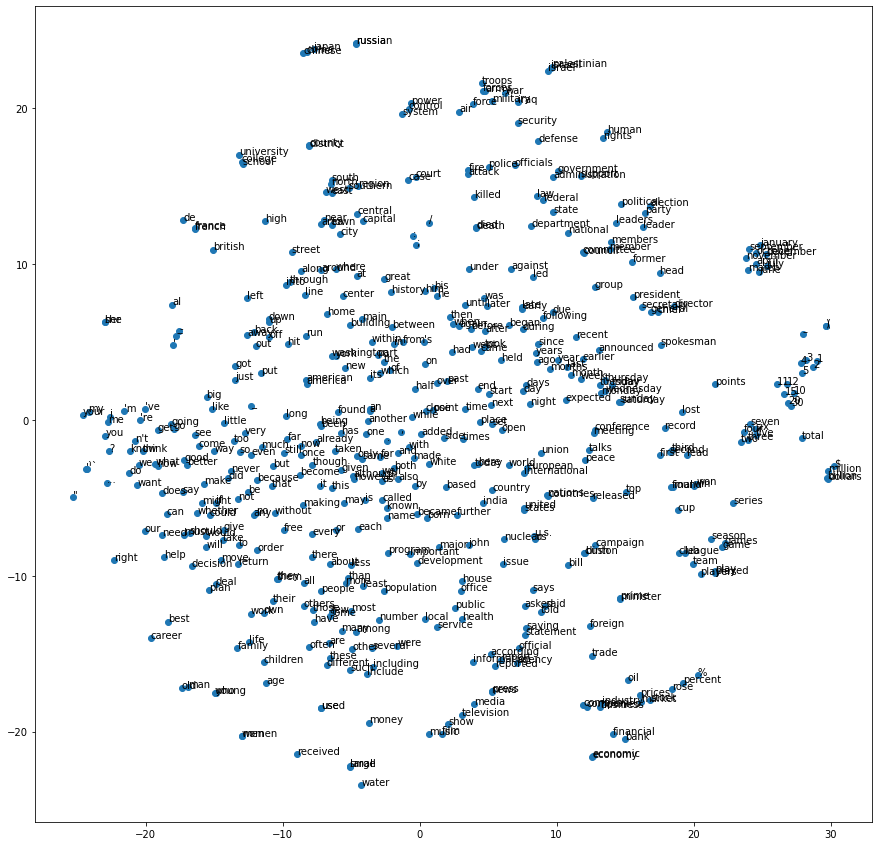

In [ ]:
#500 words
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]
Y = tsne.fit_transform(vectors[:500])
plt.figure(figsize=(15,15))
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

Logistic Regression on GloVe

In [ ]:
from sklearn.linear_model import LogisticRegression
gv = GloveVectorizer(embeddings_dict)
x_glove_train =gv.transform(X_train)
x_glove_test =gv.transform(X_test)
logreg = LogisticRegression( max_iter=250,class_weight=weighting)
logreg.fit(x_glove_train,y_train)
log_pred= logreg.predict(x_glove_test)
logreg.score(x_glove_test, y_test)*100

94.1496873108735

# Bert and CNN

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
!pip install bert-tensorflow
!pip install sentencepiece

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization

In [ ]:
#https://www.tensorflow.org/official_models/fine_tuning_bert
#https://www.kaggle.com/sofieneressifi/bert-implementation-with-tensorflow
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(X_train, tokenizer, max_len=160)
test_input = bert_encode(X_test, tokenizer, max_len=160)
train_labels = y_train


In [ ]:
random_state_split = 2
Dropout_num = 0
learning_rate = 6e-6
valid = 0.2
epochs_num = 3
batch_size_num = 16
target_corrected = False
target_big_corrected = False

model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer_9 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num
)

992/992 [==============================] - 1680s 2s/step - loss: 0.0663 - accuracy: 0.9765 - val_loss: 0.1857 - val_accuracy: 0.9498


Sorry, accidentally deleted the output for the first two epochs. The following line has the accuracy for each though.

In [ ]:
train_history.history["accuracy"]

[0.9414880275726318, 0.9518284797668457, 0.9747793078422546]

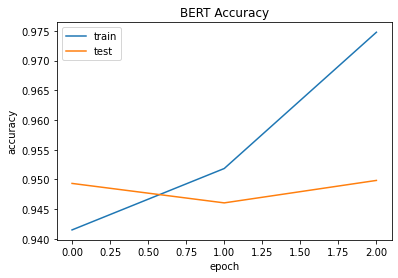

In [ ]:
# summarize history for accuracy
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('BERT Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

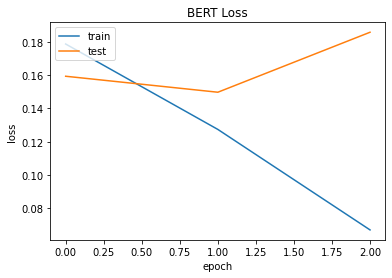

In [ ]:

# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('BERT Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()